### ASTR-324, Spring 2018, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s18/astr-324-s18


# Week 5, Thursday: Parameter estimation and model selection with MCMC. II



##### Resources for this notebook include:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.  
- [Gordon Richard's notebooks](https://github.com/gtrichards/PHYS_T480)
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:
- [Thomas Wiecki: ``MCMC sampling for dummies by Thomas Wiecki"](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)
  
##### For those who want to dive deep:
- [Andrieu et al. ``An Introduction to MCMC for Machine Learning" (includes a few pages of history)"](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)

##### Topics for this week: 
- Recap of the last week and a discussion of BIC derivation 
- Introduction to Markov Chain Monte Carlo (MCMC) methods
- MCMC applied to multi-dimensional parameter estimation
- MCMC applied to Bayesian model selection problems

## Recap: Why MCMC?

* Bayesian inference is all about deriving ***posteriors***
  * Because, once you have a posterior you can give ***accurate*** answers to questions such as:
    * What is the expected value of some parameter?
    * What is the chance a parameter value will be in some range?
    * Is model A better than model B, given the data?
    * How do I incorporate new data to get a better estimate of the knowledge of a certain parameter?


* For dimensions $\gtrsim 3$, brute-force computation of posteriors (i.e., computing all values on a grid) becomes infeasible. We need a smarter method, one that will only compute the values of the posterior where it's appreciably non-zero.

* So instead of directly computing a posterior, $p(\theta)$, we decide to ***sample it***, and use those samples to compute integrals of interest:
    $$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{M} \sum_{\{\theta_1 ... \theta_M\}} g(\theta_j).$$

* ... and Markov Chain Monte Carlo allows us to efficiently draw such samples.

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

##  Markov Chain Monte Carlo in Practice

For more involved examples, we will use two popular python modules:
PyMC and emcee. Quoting 
[Jake's blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

** emcee **

*The emcee package (also known as MCMC Hammer, which is in the running for best Python package name in history) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".*

*Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

** PyMC **

*The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. My machine has a working fortran compiler, so pip install pymc worked without a problem (but from working with students, colleagues, and tutorial attendees, I can tell you that few scientists today have a system setup such that this will work out-of-the-box). For folks who don't have a fortran compiler installed, PyMC binaries for many systems can be quite easily installed with conda.*


More details about PyMC are available from [the pyMC User Guide](https://pymc-devs.github.io/pymc/)


We will first use emcee to solve again the same problem we solved with 
homebrew MC, and then we will use pyMC to get 2-dimensional posterior pdf 
for location and scale parameters using a sample drawn from Cauchy distribution. 

## Installing with `conda`

```
conda install -c default -c conda-forge emcee
conda install pymc
```

## Sampling a Gaussian

In [11]:
import emcee
np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

def Likelihood(x,sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2/2/sigma**2))

def Prior(x):
    return 1.0/10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data)*Prior(x)

# emcee wants ln of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

# emcee combines multiple "walkers", each of which is its own MCMC chain. 
# the number of trace results will be nwalkers * nsteps
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
Nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, Nburn:, :].reshape(-1, ndim).T

print("done")

done


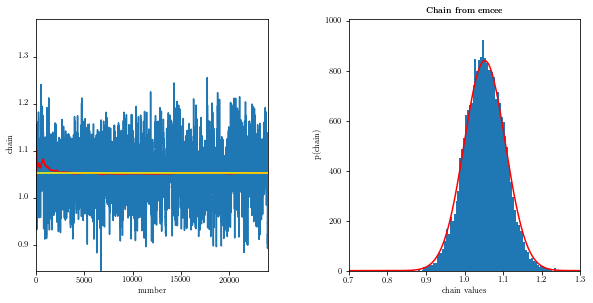

In [12]:
# plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

chainE = emcee_trace[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
x = np.linspace(1,M,M)
plt.plot(x, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number')
plt.ylabel('chain')
# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in x]
ax1.plot(x, meanC,c='red') 
ax1.plot(x, 0*x+np.mean(data),c='yellow') 

ax2 = fig.add_subplot(122)
# skip first Nburn samples
Nburn = 1000
Nchain = np.size(chainE[x>Nburn])
Nhist, bins, patches = plt.hist(chainE[x>Nburn], bins = 'auto', histtype = 'stepfilled')
# plot expectations based on CLT
binwidth = bins[1]-bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = Nchain*binwidth*stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 
ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(0.7, 1.3)
ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'{\bf Chain from emcee}')


plt.show() 

##  Markov Chain Monte Carlo with PyMC

Now we will use pyMC to get a 2-dimensional posterior pdf 
for location and scale parameters using a sample drawn from 
Cauchy distribution, which we considered earlier using 
brute force grid search method: 

<img src="figures/Lcauchy.jpg" alt="Drawing" style="width: 600px;"/>
 

 [-----------------100%-----------------] 50000 of 50000 complete in 3.4 sec

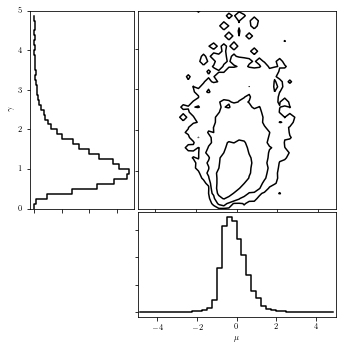

In [13]:
### let's use pyMC
## this is SIMPLIFIED code for the textbook figure 5.22, see
## http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html

# this fixes a problem when using older versions of pymc with newer
# versions of scipy
import scipy
scipy.derivative = scipy.misc.derivative
import pymc

#----------------------------------------------------------------------
# Draw the data sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

#----------------------------------------------------------------------
# Perform MCMC with pyMC:
def cauchy_logL(xi, sigma, mu):
    return ((xi.size-1)*np.log(sigma) - np.sum(np.log(sigma**2 + (xi-mu)** 2), 0))

# set up our Stochastic variables, mu and gamma
mu = pymc.Uniform('mu', -5, 5)
log_gamma = pymc.Uniform('log_gamma', -10, 10, value=0)

@pymc.deterministic
def gamma(log_gamma=log_gamma):
    return np.exp(log_gamma)

# set up our observed variable x
x = pymc.Cauchy('x', mu, gamma, observed=True, value=xi)

# set up our model dictionary
model = dict(mu=mu, log_gamma=log_gamma, gamma=gamma, x=x)

# perform the MCMC
S = pymc.MCMC(model)
S.sample(iter=50000, burn=5000)

# extract the traces we're interested in
trace_mu = S.trace('mu')[:]
trace_gamma = S.trace('gamma')[:]

# --- The End of MCMC block using pyMC ---  
#----------------------------------------------------------------------

# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace_mu, trace_gamma,
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

hist_mu, bins_mu = np.histogram(trace_mu, bins=mu_bins, normed=True)
hist_gamma, bins_gamma = np.histogram(trace_gamma, bins=gamma_bins,
                                      normed=True)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())
ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

### And now with exact solution overplotted

 [-----------------100%-----------------] 50000 of 50000 complete in 3.6 sec

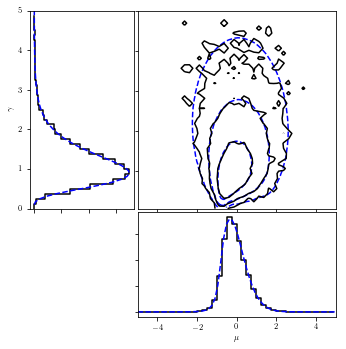

In [14]:
## this is code for the textbook figure 5.22, see
## http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html

# this fixes a problem when using older versions of pymc with newer
# versions of scipy
import scipy
scipy.derivative = scipy.misc.derivative
import pymc


def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))

#----------------------------------------------------------------------
# Draw the data sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

#----------------------------------------------------------------------
# Perform MCMC with pyMC:

# set up our Stochastic variables, mu and gamma
mu = pymc.Uniform('mu', -5, 5)
log_gamma = pymc.Uniform('log_gamma', -10, 10, value=0)


@pymc.deterministic
def gamma(log_gamma=log_gamma):
    return np.exp(log_gamma)

# set up our observed variable x
x = pymc.Cauchy('x', mu, gamma, observed=True, value=xi)

# set up our model dictionary
model = dict(mu=mu, log_gamma=log_gamma, gamma=gamma, x=x)

# perform the MCMC
S = pymc.MCMC(model)
S.sample(iter=50000, burn=5000)

# extract the traces we're interested in
trace_mu = S.trace('mu')[:]
trace_gamma = S.trace('gamma')[:]
# --- The End of MCMC block using pyMC ---  
#----------------------------------------------------------------------

# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace_mu, trace_gamma,
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

#----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace_mu, bins=mu_bins, normed=True)
hist_gamma, bins_gamma = np.histogram(trace_gamma, bins=gamma_bins,
                                      normed=True)


#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

## Modelling bursts

Imagine we observe an event with having a rapid burst, then an exponential fall-off (e.g., a _very_ simplified supernova model).

The parameters are the amplitude of the burst, $A_{true}$, the time of the burst $T_{true}$, and the exponential fall-off constant $\alpha$.

@pickle_results: computing results and saving to 'matchedfilt_burst.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 6.1 sec

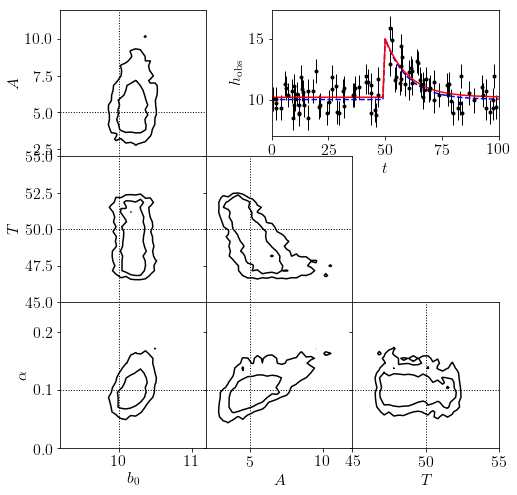

In [15]:
### AstroML book figure 10.25

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=16, usetex=True)


#----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

np.random.seed(0)

N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
sigma = 1.0

t = 100 * np.random.random(N)

# Generate the burst data -- true burst + some background
y_true = burst(t, b0_true, A_true, alpha_true, T_true)
y_obs = np.random.normal(y_true, sigma)


#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
    return burst(t, b0, A, alpha, T)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling
@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst(t_fit, *fit_vals)
y_true = burst(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show() 

##  Markov Chain Monte Carlo with PyMC

What did we just compute? 

We did MCMC fitting of a model consisting of a burst signal added to an unknown background.

Homework #4 builds on this example! 

<img src="figures/book_burst.jpg" alt="Drawing" style="width: 600px;"/>

**It is easy to modify the code to use other profiles. Let's try a Gaussian profile with heteroscedastic errors! **


 [-----------------100%-----------------] 25000 of 25000 complete in 5.8 sec

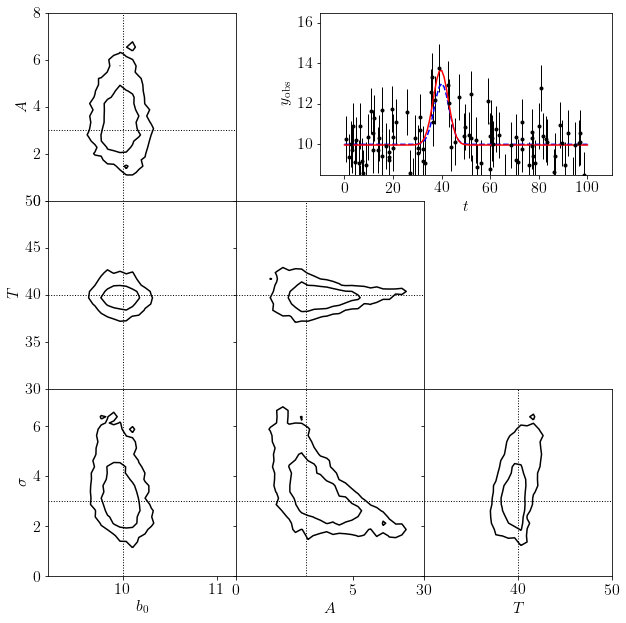

In [16]:
### Modeled after AstroML book figure 10.25
## burst model replaced by gaussian profile

#----------------------------------------------------------------------
# Set up toy dataset
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y

np.random.seed(42)
N = 101
b0_true = 10
A_true = 3
sigma_true = 3.0
T_true = 40
err0_y = 0.5

t = 100 * np.random.random(N)
y_true = GaussAndBkgd(t, b0_true, A_true, sigma_true, T_true)
err_y = np.random.uniform(0, 2*err0_y) + 0.5*np.sqrt(y_true/10) 
y_obs = np.random.normal(y_true, err_y)

labels = ['$b_0$', '$A$', '$T$', r'$\sigma$']
limits = [(9.2, 11.2), (0, 8), (30, 50), (0.0, 7.5)]
true = [b0_true, A_true, T_true, sigma_true]

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
log_sigma = pymc.Uniform('log_sigma', -2, 2, value=0.1)


# uniform prior on log(alpha)
@pymc.deterministic
def sigma(log_sigma=log_sigma):
    return np.exp(log_sigma)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, sigma=sigma, T=T):
    return GaussAndBkgd(t, b0, A, sigma, T)

y = pymc.Normal('y', mu=y_model, tau=err_y ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_sigma=log_sigma, sigma=sigma, y_model=y_model, y=y)

#----------------------------------------------------------------------
# Run the MCMC sampling
#@pickle_results('matchedfilt_gauss.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'sigma']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.sigma.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = GaussAndBkgd(t_fit, *fit_vals)
y_true = GaussAndBkgd(t_fit, b0_true, A_true, sigma_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, err_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(-10, 110)
ax.set_ylim(8.5, 16.5)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show() 

## Importance of Posteriors: A Cosmological Example

<img src="figures/lcdm-posteriors.jpg" style="width: 600px;"/>

-- from http://www.ita.uni-heidelberg.de/~jmerten/cosmology.shtml?lang%3Dde

## Mixture models

We frequently encounter cases where we obtain data that show certain multi-modal behavior (i.e., have "multiple peaks"). It's useful to try to see whether a ***mixture*** of simple models (typically, Gaussians) can explain the data, and how many simple models are sufficient to explain the data.

Examples:
* Unresolved ("blended") stars that are very close together.
* Overlapping stellar systems
* Overlapping asteroid families
* ... many others ...

Questions:
* What is the number of components in the mixture that best explains the data?
* What are the values of those components' parameters?

Below is an example of a simulated datasets with 4 Gaussian components, with observational errors, and our fit to those data.

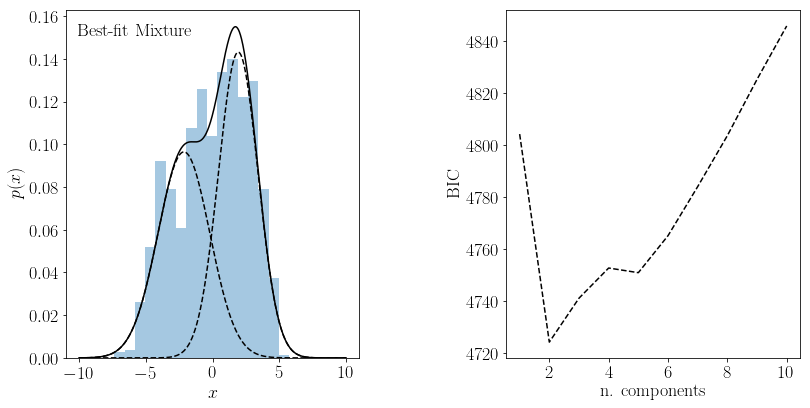

In [17]:
### Modeled after astroML book figure 4.2  

from sklearn.mixture import GMM
setup_text_plots(fontsize=18, usetex=True)

def doGMM(Ndata, noiseStd=0.00000001):
    #------------------------------------------------------------
    # Set up the dataset.
    #  We'll use scikit-learn's Gaussian Mixture Model to sample
    #  data from a mixture of Gaussians.  The usual way of using
    #  this involves fitting the mixture to data: we'll see that
    #  below.  Here we'll set the internal means, covariances,
    #  and weights by-hand.
    np.random.seed(1)
    gmm = GMM(4, n_iter=1)
    gmm.means_ = np.array([[-4], [-1], [0.9], [3]])
    gmm.covars_ = np.array([[1.1], [1.0], [0.7], [0.8]]) ** 2
    gmm.weights_ = np.array([0.2, 0.3, 0.2, 0.3])

    X = gmm.sample(Ndata)
    # convolution by "measurement" errors
    X = np.random.normal(X, noiseStd)
    
    #------------------------------------------------------------
    # Learn (train) the best-fit GMM models
    # Here we'll use GMM in the standard way: the fit() method
    # uses an Expectation-Maximization approach to find the best
    # mixture of Gaussians for the data

    # fit models with 1-10 components
    N = np.arange(1, 11)
    models = [None for i in range(len(N))]
    
    for i in range(len(N)):
        models[i] = GMM(N[i]).fit(X)

    # compute the BIC
    BIC = [m.bic(X) for m in models]

    #------------------------------------------------------------
    # Plot the results
    #  We'll use two panels:
    #   1) data + best-fit mixture
    #   2) BIC vs number of components 

    fig = plt.figure(figsize=(12, 7))
    fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    M_best = models[np.argmin(BIC)]

    x = np.linspace(-10, 10, 1000)
    logprob, responsibilities = M_best.score_samples(x.reshape((-1,1))) ## fix
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.hist(X, 'auto', normed=True, histtype='stepfilled', alpha=0.4)
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')


    # plot 2: BIC
    ax = fig.add_subplot(122)
    ax.plot(N, BIC, '--k')
    ax.set_xlabel('n. components')
    ax.set_ylabel('BIC')

    plt.show()
    
doGMM(1000)    

##  How do we interpret BIC? 

The figure above (right panel) shows that the 2-component model has a BIC lower
by about 15 than the 3-component model. Is this sufficient evidence to claim 
that the former is really really better choice than the latter? 

As you may recall, we said in Week 4 Thu lecture:

**How do we interpret the values of the odds ratio in practice? **
Jeffreys proposed a five-step scale for interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ is ten times more probable than $M_1$), and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred times more probable than $M_1$). When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”

Given the relationship between the BIC and $O_{21},$ 
$$    \Delta BIC \equiv BIC_2 - BIC_1 = -2\,\ln(O_{21}) $$ 
we have that $O_{21}=10$ corresponds to $\Delta BIC= -4.6$ and $O_{21}=100$ corresponds to $\Delta BIC = -9.2$.
For completeness, $|\Delta BIC|<2$ is “not worth more than a bare mention.”

Therefore, ** $|\Delta BIC| = 5$ corresponds to “strong” evidence and $|\Delta BIC| = 10$ to “decisive” evidence.**

We can conclude that the figure shows **decisive** evidence in favor of the 2-component model. That is,
you should **not** argue that there are 3 peaks in the left panel! Altough we **did** draw that dataset
from a model with more than 2 components (4 actually), a sample of 1000 values is insufficient to 
*discover* more than 2 components!

What if we increase the sample size? 

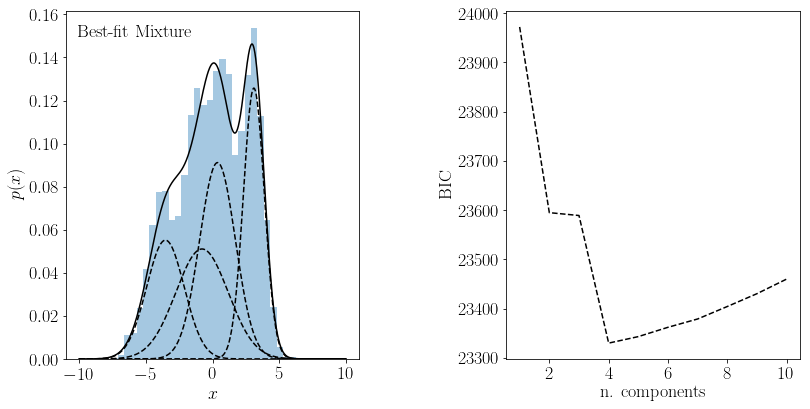

In [18]:
doGMM(5000)

**Conclusion** Large sample size helps! I love surveys, I love LSST! 

But one more thing: let's convolve our data with an arbitrary Gaussian 
to simulate measurement errors. 

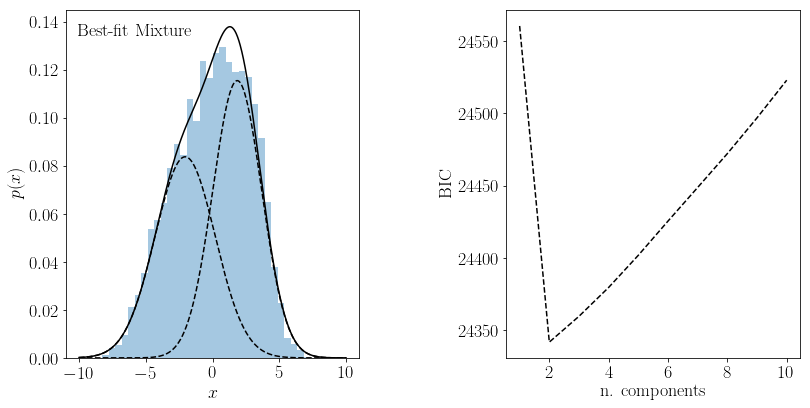

In [19]:
doGMM(5000,1.0)

**Conclusion** Duh! If you badly "blur" your sample, of course you will not see the fine
structure (i.e. many components)! 

Therefore, even with large samples, you still need to have precise and well calibrated 
measurements! Another reason to love LSST! 
 